In [1]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms




# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *
from apmeter import *
from train_valid_split import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [2]:
def plot_loss(trn_hist, val_hist, loss_acc):
    plt.plot(trn_hist, label='Training ' + loss_acc)
    plt.plot(val_hist, label='Validation ' + loss_acc)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel(loss_acc)
    plt.show()

In [ ]:
def freeze_bn(m):
    if isinstance(m, nn.BatchNorm2d):
        m.eval()

In [3]:
use_gpu = True
cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if (cuda_available and use_gpu) else "cpu")

In [4]:
DATA_DIR = "F:/MyArticel/DTASET/NEW DATASETTT/willow_orgin_20_from_test/mask_pose/"

sz = 224
batch_size = 16

In [5]:
os.listdir(DATA_DIR)

['test', 'train', 'valid']

In [6]:
trn_dir = f'{DATA_DIR}train'
val_dir = f'{DATA_DIR}valid'

In [7]:
os.listdir(trn_dir)

['InteractingWithComputer',
 'Photographing',
 'PlayingMusic',
 'RidingBike',
 'RidingHorse',
 'Running',
 'Walking']

In [8]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.jpg')
trn_fnames[:5]

['F:/MyArticel/DTASET/NEW DATASETTT/willow_orgin_20_from_test/mask_pose/train\\InteractingWithComputer\\action0002.jpg',
 'F:/MyArticel/DTASET/NEW DATASETTT/willow_orgin_20_from_test/mask_pose/train\\InteractingWithComputer\\action0004.jpg',
 'F:/MyArticel/DTASET/NEW DATASETTT/willow_orgin_20_from_test/mask_pose/train\\InteractingWithComputer\\action0005.jpg',
 'F:/MyArticel/DTASET/NEW DATASETTT/willow_orgin_20_from_test/mask_pose/train\\InteractingWithComputer\\action0006.jpg',
 'F:/MyArticel/DTASET/NEW DATASETTT/willow_orgin_20_from_test/mask_pose/train\\InteractingWithComputer\\action0007.jpg']

In [9]:
# LOAD DATA
train_ds = datasets.ImageFolder(trn_dir)

In [10]:
train_ds.classes

['InteractingWithComputer',
 'Photographing',
 'PlayingMusic',
 'RidingBike',
 'RidingHorse',
 'Running',
 'Walking']

In [11]:
train_ds.class_to_idx

{'InteractingWithComputer': 0,
 'Photographing': 1,
 'PlayingMusic': 2,
 'RidingBike': 3,
 'RidingHorse': 4,
 'Running': 5,
 'Walking': 6}

In [12]:
train_ds.root

'F:/MyArticel/DTASET/NEW DATASETTT/willow_orgin_20_from_test/mask_pose/train'

In [13]:
type(train_ds.transform)

NoneType

In [14]:

# Data augmentation and normalization for training 
train_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(20),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f'{DATA_DIR}train', train_transforms)
#valid_ds = datasets.ImageFolder(f'{DATA_DIR}valid', valid_transforms)

train_ds, valid_ds = train_valid_split(train_ds, 10)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print('Train size: {}\nValid size: {} ({:.2f})'.format(train_ds_sz, valid_ds_sz, valid_ds_sz/(train_ds_sz + valid_ds_sz)))

class_names = train_ds.mother.classes

Train size: 429
Valid size: 99 (0.19)


In [15]:
len (train_ds), len (valid_ds)

(429, 99)

In [16]:
# dataloader
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, 
                                       shuffle=True, num_workers=4)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, 
                                       shuffle=True, num_workers=4)

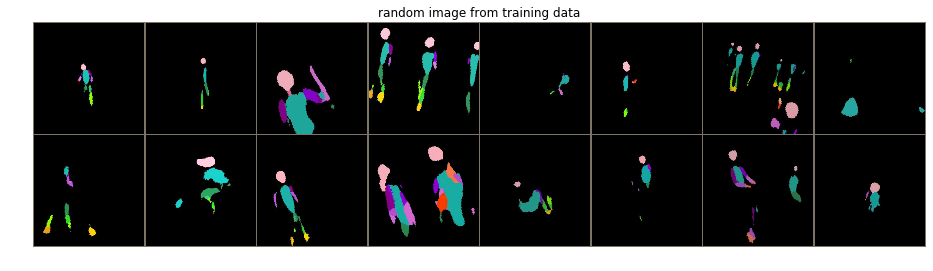

In [17]:
inputs,targets =  next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title='random image from training data')

In [18]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# load pre-trained ResNet50
model = load_pretrained_resnet50(model_path=None, num_classes=7)
model.apply(freeze_bn)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0003, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0002)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.95)

model = model.to(device)
criterion = criterion.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [19]:
# training
model, trn_loss_hist, val_loss_hist, trn_acc_hist, val_acc_hist = train_model(model, train_dl, valid_dl, criterion, optimizer, scheduler, num_epochs=15)

Epoch 1/15
----------
  train Loss: 1.97035 Acc: 0.16084
  valid Loss: 1.92280 Acc: 0.23232

Epoch 2/15
----------
  train Loss: 1.89225 Acc: 0.24009
  valid Loss: 1.86904 Acc: 0.25253

Epoch 3/15
----------
  train Loss: 1.83140 Acc: 0.27506
  valid Loss: 1.85112 Acc: 0.30303

Epoch 4/15
----------
  train Loss: 1.76072 Acc: 0.33800
  valid Loss: 1.78662 Acc: 0.34343

Epoch 5/15
----------
  train Loss: 1.71010 Acc: 0.37529
  valid Loss: 1.76919 Acc: 0.36364

Epoch 6/15
----------
  train Loss: 1.65753 Acc: 0.38462
  valid Loss: 1.72585 Acc: 0.40404

Epoch 7/15
----------
  train Loss: 1.61256 Acc: 0.46154
  valid Loss: 1.68034 Acc: 0.36364

Epoch 8/15
----------
  train Loss: 1.57036 Acc: 0.43823
  valid Loss: 1.62589 Acc: 0.38384

Epoch 9/15
----------
  train Loss: 1.54303 Acc: 0.49883
  valid Loss: 1.61894 Acc: 0.37374

Epoch 10/15
----------
  train Loss: 1.49964 Acc: 0.51049
  valid Loss: 1.62377 Acc: 0.35354

Epoch 11/15
----------
  train Loss: 1.45437 Acc: 0.52448
  valid Los

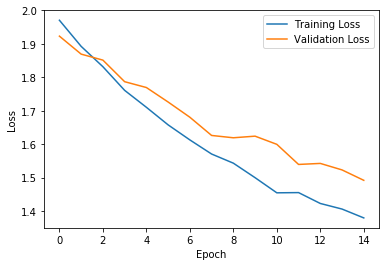

In [20]:
loss_acc = 'Loss'
plot_loss(trn_loss_hist, val_loss_hist, loss_acc)

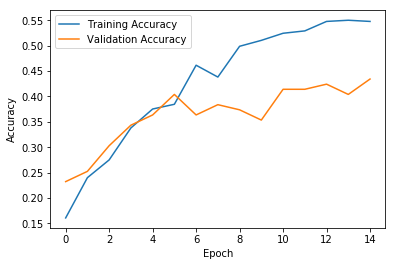

In [21]:
loss_acc = 'Accuracy'
plot_loss(trn_acc_hist, val_acc_hist, loss_acc)

In [31]:
for param in model.parameters():
    param.require_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)
model = model.to(device)
criterion = criterion.to(device)

In [32]:
model, trn_loss_hist1, val_loss_hist1, trn_acc_hist1, val_acc_hist1 = train_model(model, train_dl, valid_dl, criterion, optimizer, scheduler, num_epochs=50)

Epoch 1/50
----------
  train Loss: 1.13381 Acc: 0.63403
  valid Loss: 1.39163 Acc: 0.41414

Epoch 2/50
----------
  train Loss: 1.14994 Acc: 0.62005
  valid Loss: 1.37682 Acc: 0.44444

Epoch 3/50
----------
  train Loss: 1.11017 Acc: 0.63869
  valid Loss: 1.42477 Acc: 0.44444

Epoch 4/50
----------
  train Loss: 1.09855 Acc: 0.66200
  valid Loss: 1.38946 Acc: 0.46465

Epoch 5/50
----------
  train Loss: 1.07581 Acc: 0.66434
  valid Loss: 1.32340 Acc: 0.45455

Epoch 6/50
----------
  train Loss: 1.10302 Acc: 0.64569
  valid Loss: 1.31591 Acc: 0.45455

Epoch 7/50
----------
  train Loss: 1.06721 Acc: 0.67599
  valid Loss: 1.40143 Acc: 0.44444

Epoch 8/50
----------
  train Loss: 1.04655 Acc: 0.66667
  valid Loss: 1.26221 Acc: 0.44444

Epoch 9/50
----------
  train Loss: 1.01746 Acc: 0.69231
  valid Loss: 1.26201 Acc: 0.49495

Epoch 10/50
----------
  train Loss: 0.99672 Acc: 0.69697
  valid Loss: 1.36145 Acc: 0.47475

Epoch 11/50
----------
  train Loss: 1.02270 Acc: 0.66434
  valid Los

In [33]:
trn_loss_hist.extend(trn_loss_hist1)
val_loss_hist.extend(val_loss_hist1)
trn_acc_hist.extend(trn_acc_hist1)
val_acc_hist.extend(val_acc_hist1)

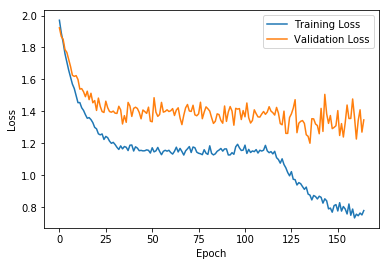

In [34]:
loss_acc = 'Loss'
plot_loss(trn_loss_hist, val_loss_hist, loss_acc)

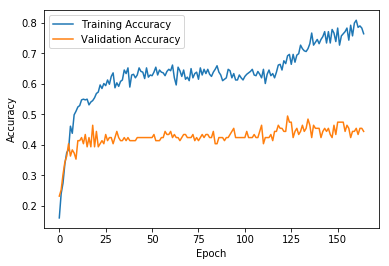

In [35]:
loss_acc = 'Accuracy'
plot_loss(trn_acc_hist, val_acc_hist, loss_acc)

In [36]:
# acuracy on validation data

def evaluate_model(model, dataloader):
    model.eval()  # for batch normalization layers
    corrects = 0
    for inputs, targets in dataloader:
        inputs, targets = to_var(inputs, True), to_var(targets, True)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [37]:
# mAP
m = torch.nn.Softmax(dim=1)
def calculate_model_mAP(model, dataloader):
    mAP = APMeter()
    model.eval()  # for batch normalization layers
    corrects = 0
    for inputs, targets in dataloader:
        inputs, targets = to_var(inputs, True), to_var(targets, True)
        outputs = model(inputs)
        outputs = m(outputs)
        targets.resize_(targets.size(0), 1)
        targets = Variable(targets)
        
        one_hot = torch.cuda.FloatTensor(targets.size(0), outputs.size(1)).zero_()
        one_hot.scatter_(1, targets.data, 1)
        one_hot = Variable(one_hot)
        mAP.add(outputs,one_hot)

        #print(outputs.data)
    
    for i, value in enumerate(mAP.value()):
        print(train_ds.classes[i], ' AP: {:.2f}'.format(100. * value))
    print('mAP: {:.2f}'.format(100. * mAP.value().sum() / mAP.value().size(0)))

In [ ]:
evaluate_model(model, valid_dl)

In [ ]:
evaluate_model(model, train_dl)

In [ ]:
visualize_model(model, train_dl)

In [ ]:
visualize_model(model, valid_dl)

In [ ]:
plot_errors(model, train_dl)

In [ ]:
# confusion matrix
y_pred, y_true = predict_class(model, valid_dl)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(12,12 ))

In [ ]:
# Look at the sizes of the images

fnames = glob.glob(f'{trn_dir}/*/*.png')
sizes = [Image.open(f).size for f in fnames]

hs, ws = list(zip(*sizes))

plt.figure(figsize=(12., 4.))
plt.hist(hs)
plt.hist(ws);

In [ ]:
visualize_model(model, valid_dl, num_images=6)

In [ ]:
plot_errors(model, valid_dl)

In [38]:
### testing

class_names = train_ds.classes
test_dir = f'{DATA_DIR}\\test'
test_ds = datasets.ImageFolder(test_dir,valid_transforms)
len(test_ds)

399

In [39]:
### dataloder

test_dl =  torch.utils.data.DataLoader(test_ds,batch_size= batch_size, num_workers=8)

In [ ]:
pred_class_names, y = predict_class_names(model, test_dl, class_names)

test_fnames= glob.glob(f'{test_dir}/*/*.png')
len(test_fnames), test_fnames [:5]

In [ ]:
test_fnames_len= len(test_fnames)
for i in range(test_fnames_len):
    test_fnames[i] = os.path.basename(test_fnames[i])
    
    len(test_fnames), test_fnames[:5]

In [ ]:
pred_result = np.stack([test_fnames, pred_class_names], axis=1)
len(pred_result), pred_result

In [41]:
evaluate_model(model, test_dl)

accuracy: 40.00


In [40]:
calculate_model_mAP(model, test_dl)

InteractingWithComputer  AP: 30.23
Photographing  AP: 38.54
PlayingMusic  AP: 49.92
RidingBike  AP: 57.45
RidingHorse  AP: 56.93
Running  AP: 47.43
Walking  AP: 43.04
mAP: 46.22


In [ ]:
plot_errors(model, test_dl)

In [ ]:
# confusion matrix
y_pred, y_true = predict_class(model, test_dl)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(12,12 ))